In [13]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-is0tu_ex
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-is0tu_ex
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.1.3-py3-none-any.whl size=83164 sha256=828b1a73f6c1871a6366f72629ea31656a5d6cd2ca37823b7483125de4139f17
  Stored in directory: /tmp/pip-ephem-wheel-cache-cxn59cr_/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
Successfully built segmentation-models-pytorch


In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score
import cv2

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.4.0
GPU 사용 가능 여부: True
Tesla P40
1


In [2]:
batch_size = 16   # Mini-batch size

In [3]:
%matplotlib inline

dataset_path = '../input/data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


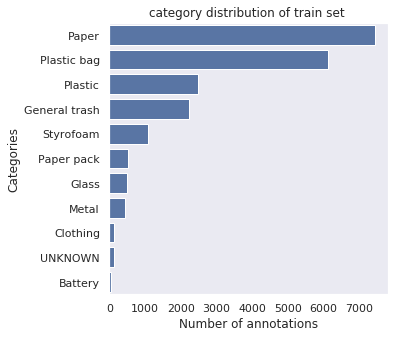

In [4]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [5]:

sorted_temp_df = df.sort_index()
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.uint8)
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.uint8)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
                
            images = images.type(torch.float32)
            
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
                
            images = images.type(torch.float32)
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

In [6]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

test_transform = A.Compose([
                            A.Normalize(
                                mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0
                            ),    
                        ToTensorV2(transpose_mask=True)
        ])

test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)

# DataLoader
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=2,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [7]:
def ensemble_test(models, test_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    for i in range(len(models)) :
        models[i].eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(test_loader):
            outs_list = []

            # inference (512 x 512)
            for i in range(len(models)):
                out = models[i](torch.stack(imgs).to(device))
                outs_list.append(out)
            
            outs = outs_list[0]
            for i in range(1, len(outs_list)):
                outs += outs_list[i]
                
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

In [8]:
model1 = smp.DeepLabV3Plus(
    encoder_name="se_resnext101_32x4d",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=12,                      # model output channels (number of classes in your dataset)
)

model2 = smp.DeepLabV3Plus(
    encoder_name="se_resnext101_32x4d",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=12,                      # model output channels (number of classes in your dataset)
)

model3 = smp.DeepLabV3Plus(
    encoder_name="se_resnext101_32x4d",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=12,                      # model output channels (number of classes in your dataset)
)

model4 = smp.DeepLabV3Plus(
    encoder_name="se_resnext101_32x4d",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=12,                      # model output channels (number of classes in your dataset)
)

model5 = smp.DeepLabV3Plus(
    encoder_name="se_resnext101_32x4d",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=12,                      # model output channels (number of classes in your dataset)
)

model6 = smp.DeepLabV3Plus(
    encoder_name="se_resnext101_32x4d",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=12,                      # model output channels (number of classes in your dataset)
)

model7 = smp.DeepLabV3Plus(
    encoder_name="senet154",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=12,                      # model output channels (number of classes in your dataset)
)

model8 = smp.DeepLabV3Plus(
    encoder_name="se_resnext101_32x4d",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=12,                      # model output channels (number of classes in your dataset)
)

model9 = smp.DeepLabV3Plus(
    encoder_name="senet154",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=12,                      # model output channels (number of classes in your dataset)
)

model10 = smp.DeepLabV3Plus(
    encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=12,                      # model output channels (number of classes in your dataset)
)

model11 = smp.DeepLabV3Plus(
    encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=12,                      # model output channels (number of classes in your dataset)
)

model12 = smp.DeepLabV3Plus(
    encoder_name="efficientnet-b4",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=12,                      # model output channels (number of classes in your dataset)
)

model13 = smp.DeepLabV3Plus(
    encoder_name="efficientnet-b4",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=12,                      # model output channels (number of classes in your dataset)
)

# best model 저장된 경로
model_path1 = './saved/fold1-2.pth'
model_path2 = './saved/fold2-2.pt'
model_path3 = './saved/fold3-2.pt'
model_path4 = './saved/fold4-2.pt'
model_path5 = './saved/fold5-1.pt'
model_path6 = './saved/se_resnext_hcw.pth'
model_path7 = './saved/senet154_cym.pt'
model_path8 = './saved/se_resnet101_hcw.pth'
model_path9 = './saved/senet154_cym2.pt'
model_path10 = './saved/efficientnet-b7_ksh.pt'
model_path11 = './saved/efficientnet-b7_ksh2.pt'
model_path12 = './saved/efficientnet-b4_ksh.pt'
model_path13 = './saved/efficientnet-b4_ksh2.pt'

# best model 불러오기
checkpoint1 = torch.load(model_path1, map_location=device)
checkpoint2 = torch.load(model_path2, map_location=device)
checkpoint3 = torch.load(model_path3, map_location=device)
checkpoint4 = torch.load(model_path4, map_location=device)
checkpoint5 = torch.load(model_path5, map_location=device)
checkpoint6 = torch.load(model_path6, map_location=device)
checkpoint7 = torch.load(model_path7, map_location=device)
checkpoint8 = torch.load(model_path8, map_location=device)
checkpoint9 = torch.load(model_path9, map_location=device)
checkpoint10 = torch.load(model_path10, map_location=device)
checkpoint11 = torch.load(model_path11, map_location=device)
checkpoint12 = torch.load(model_path12, map_location=device)
checkpoint13 = torch.load(model_path13, map_location=device)

'''
# DeepLab을 사용시에는 아래와 같이 사용 
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[-1] = nn.Conv2d(256, 12, kernel_size=1, stride=1)
'''
models = []

model1.load_state_dict(checkpoint1)
model1 = model1.to(device)
models.append(model1)

model2.load_state_dict(checkpoint2)
model2 = model2.to(device)
models.append(model2)

model3.load_state_dict(checkpoint3)
model3 = model3.to(device)
models.append(model3)

model4.load_state_dict(checkpoint4)
model4 = model4.to(device)
models.append(model4)

model5.load_state_dict(checkpoint5)
model5 = model5.to(device)
models.append(model5)

model6.load_state_dict(checkpoint6)
model6 = model6.to(device)
models.append(model6)

model7.load_state_dict(checkpoint7)
model7 = model7.to(device)
models.append(model7)

model8.load_state_dict(checkpoint8)
model8 = model8.to(device)
models.append(model8)

model9.load_state_dict(checkpoint9)
model9 = model9.to(device)
models.append(model9)

model10.load_state_dict(checkpoint10, strict=False)
model10 = model10.to(device)
models.append(model10)

model11.load_state_dict(checkpoint11, strict=False)
model11 = model11.to(device)
models.append(model11)

model12.load_state_dict(checkpoint12, strict=False)
model12 = model12.to(device)
models.append(model12)

model13.load_state_dict(checkpoint13, strict=False)
model13 = model13.to(device)
models.append(model13)

# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
# model.eval()


In [9]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = ensemble_test(models, test_loader, device) ###########################

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/ensemble.csv", index=False)

Start prediction.
End prediction.
